## Librerias

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Deshabilitar el modo interactivo
plt.ioff()

## Funciones

In [2]:
class Graficador:

    def __init__(self):
        pass

    def create_subplots_one_var(self,data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)

        for column in data.columns:

            # Creacion del grafico de barras
            graph(data = data[[column]], ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

    def create_subplots_one_var_group(self, data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)
        data_temp = data[::]
        data_temp['temp'] = 0
        for column in data_temp.columns:
            
            if column == 'temp':
                continue

            temp = data_temp[[column, 'temp']].groupby(column, as_index = False).count().rename(columns = {'temp' : 'Conteo'})
            # Creacion del grafico de barras
            graph(data = temp, x = column, y = 'Conteo', ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

def create_apilated_bars(data):

    grupos = data.columns

    fig, ax = plt.subplots()
    values = data.values

    for i in range(values.shape[0]):
        ax.bar(grupos, values[i], bottom = np.sum(values[:i], axis = 0), label = data.index[i])
        # Agregar títulos a los ejes

    return fig,ax


## Parametros

In [3]:
client_bq = bigquery.Client()

In [4]:
table = 'Diabetes_avicena_survival.diabetes_final'

numeric_columns = ['edad','peso','talla','HDL','LDL','trigliceridos','perimetro_abdominal','time_to_event']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

In [5]:
graficador = Graficador()

## Proceso

In [6]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (9024, 20) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,1007107070,2022,8,2022-08-01,19,56.0,1.61,56.0,99.00,95.00,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
1,26151819,2022,8,2022-08-01,70,82.0,1.59,45.3,158.00,238.00,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1
2,93396738,2022,8,2022-08-01,47,85.2,1.60,44.0,174.06,90.13,103.0,Masculino,Otros,Profesional,0,0,0,Nunca,0,1
3,43524938,2024,1,2024-01-01,56,56.0,1.55,51.0,143.40,254.70,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0,1
4,94426911,2024,1,2024-01-01,50,91.0,1.75,38.0,150.80,211.00,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0,1


In [7]:
## Cantidad de pacientes con diabetes
data[['numero_identificacion_paciente','diabetes']].drop_duplicates().groupby('diabetes', as_index = False).count()

,diabetes,numero_identificacion_paciente
0,0,7524
1,1,1500


In [8]:
# Dataframe con los datos numericos
df_numerico = data[numeric_columns]

df_numerico.head()

,edad,peso,talla,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
0,19,56.0,1.61,56.0,99.00,95.00,75.0,1
1,70,82.0,1.59,45.3,158.00,238.00,96.0,1
2,47,85.2,1.60,44.0,174.06,90.13,103.0,1
3,56,56.0,1.55,51.0,143.40,254.70,74.5,1
4,50,91.0,1.75,38.0,150.80,211.00,95.0,1


In [9]:
# Dataframe con los datos categoricos
df_categorico = data[categoric_columns + [target]].astype(str)

df_categorico.head()

,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes
0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1
1,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0
2,Masculino,Otros,Profesional,0,0,0,Nunca,0
3,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0
4,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0


## One Variable

In [10]:
## informacion de la data
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9024 entries, 0 to 9023
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   edad                 9024 non-null   Int64  
 1   peso                 9024 non-null   float64
 2   talla                9024 non-null   float64
 3   HDL                  9024 non-null   float64
 4   LDL                  9024 non-null   float64
 5   trigliceridos        9024 non-null   float64
 6   perimetro_abdominal  9024 non-null   float64
 7   time_to_event        9024 non-null   Int64  
dtypes: Int64(2), float64(6)
memory usage: 581.8 KB


In [11]:
## Descripcion de los datos
df_numerico.describe()

,edad,peso,talla,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
count,9024.0,9024.000000,9024.000000,9024.000000,9024.000000,9024.000000,9024.000000,9024.0
mean,58.734043,74.464027,1.613710,48.330509,113.308569,154.365631,94.042366,15.493019
std,15.300513,16.506875,0.094892,13.116570,40.310675,95.879518,12.914949,9.591834
min,18.0,30.650000,0.670000,11.000000,0.000000,1.280000,30.000000,1.0
25%,48.0,63.000000,1.550000,39.100000,85.000000,98.250000,85.500000,7.0
50%,60.0,72.900000,1.600000,46.500000,111.260000,134.000000,94.000000,15.0
75%,69.0,83.537500,1.680000,55.000000,137.500000,186.000000,102.000000,23.0
max,102.0,200.600000,1.960000,198.900000,640.500000,2124.000000,170.000000,36.0


Grafico de distribuciones


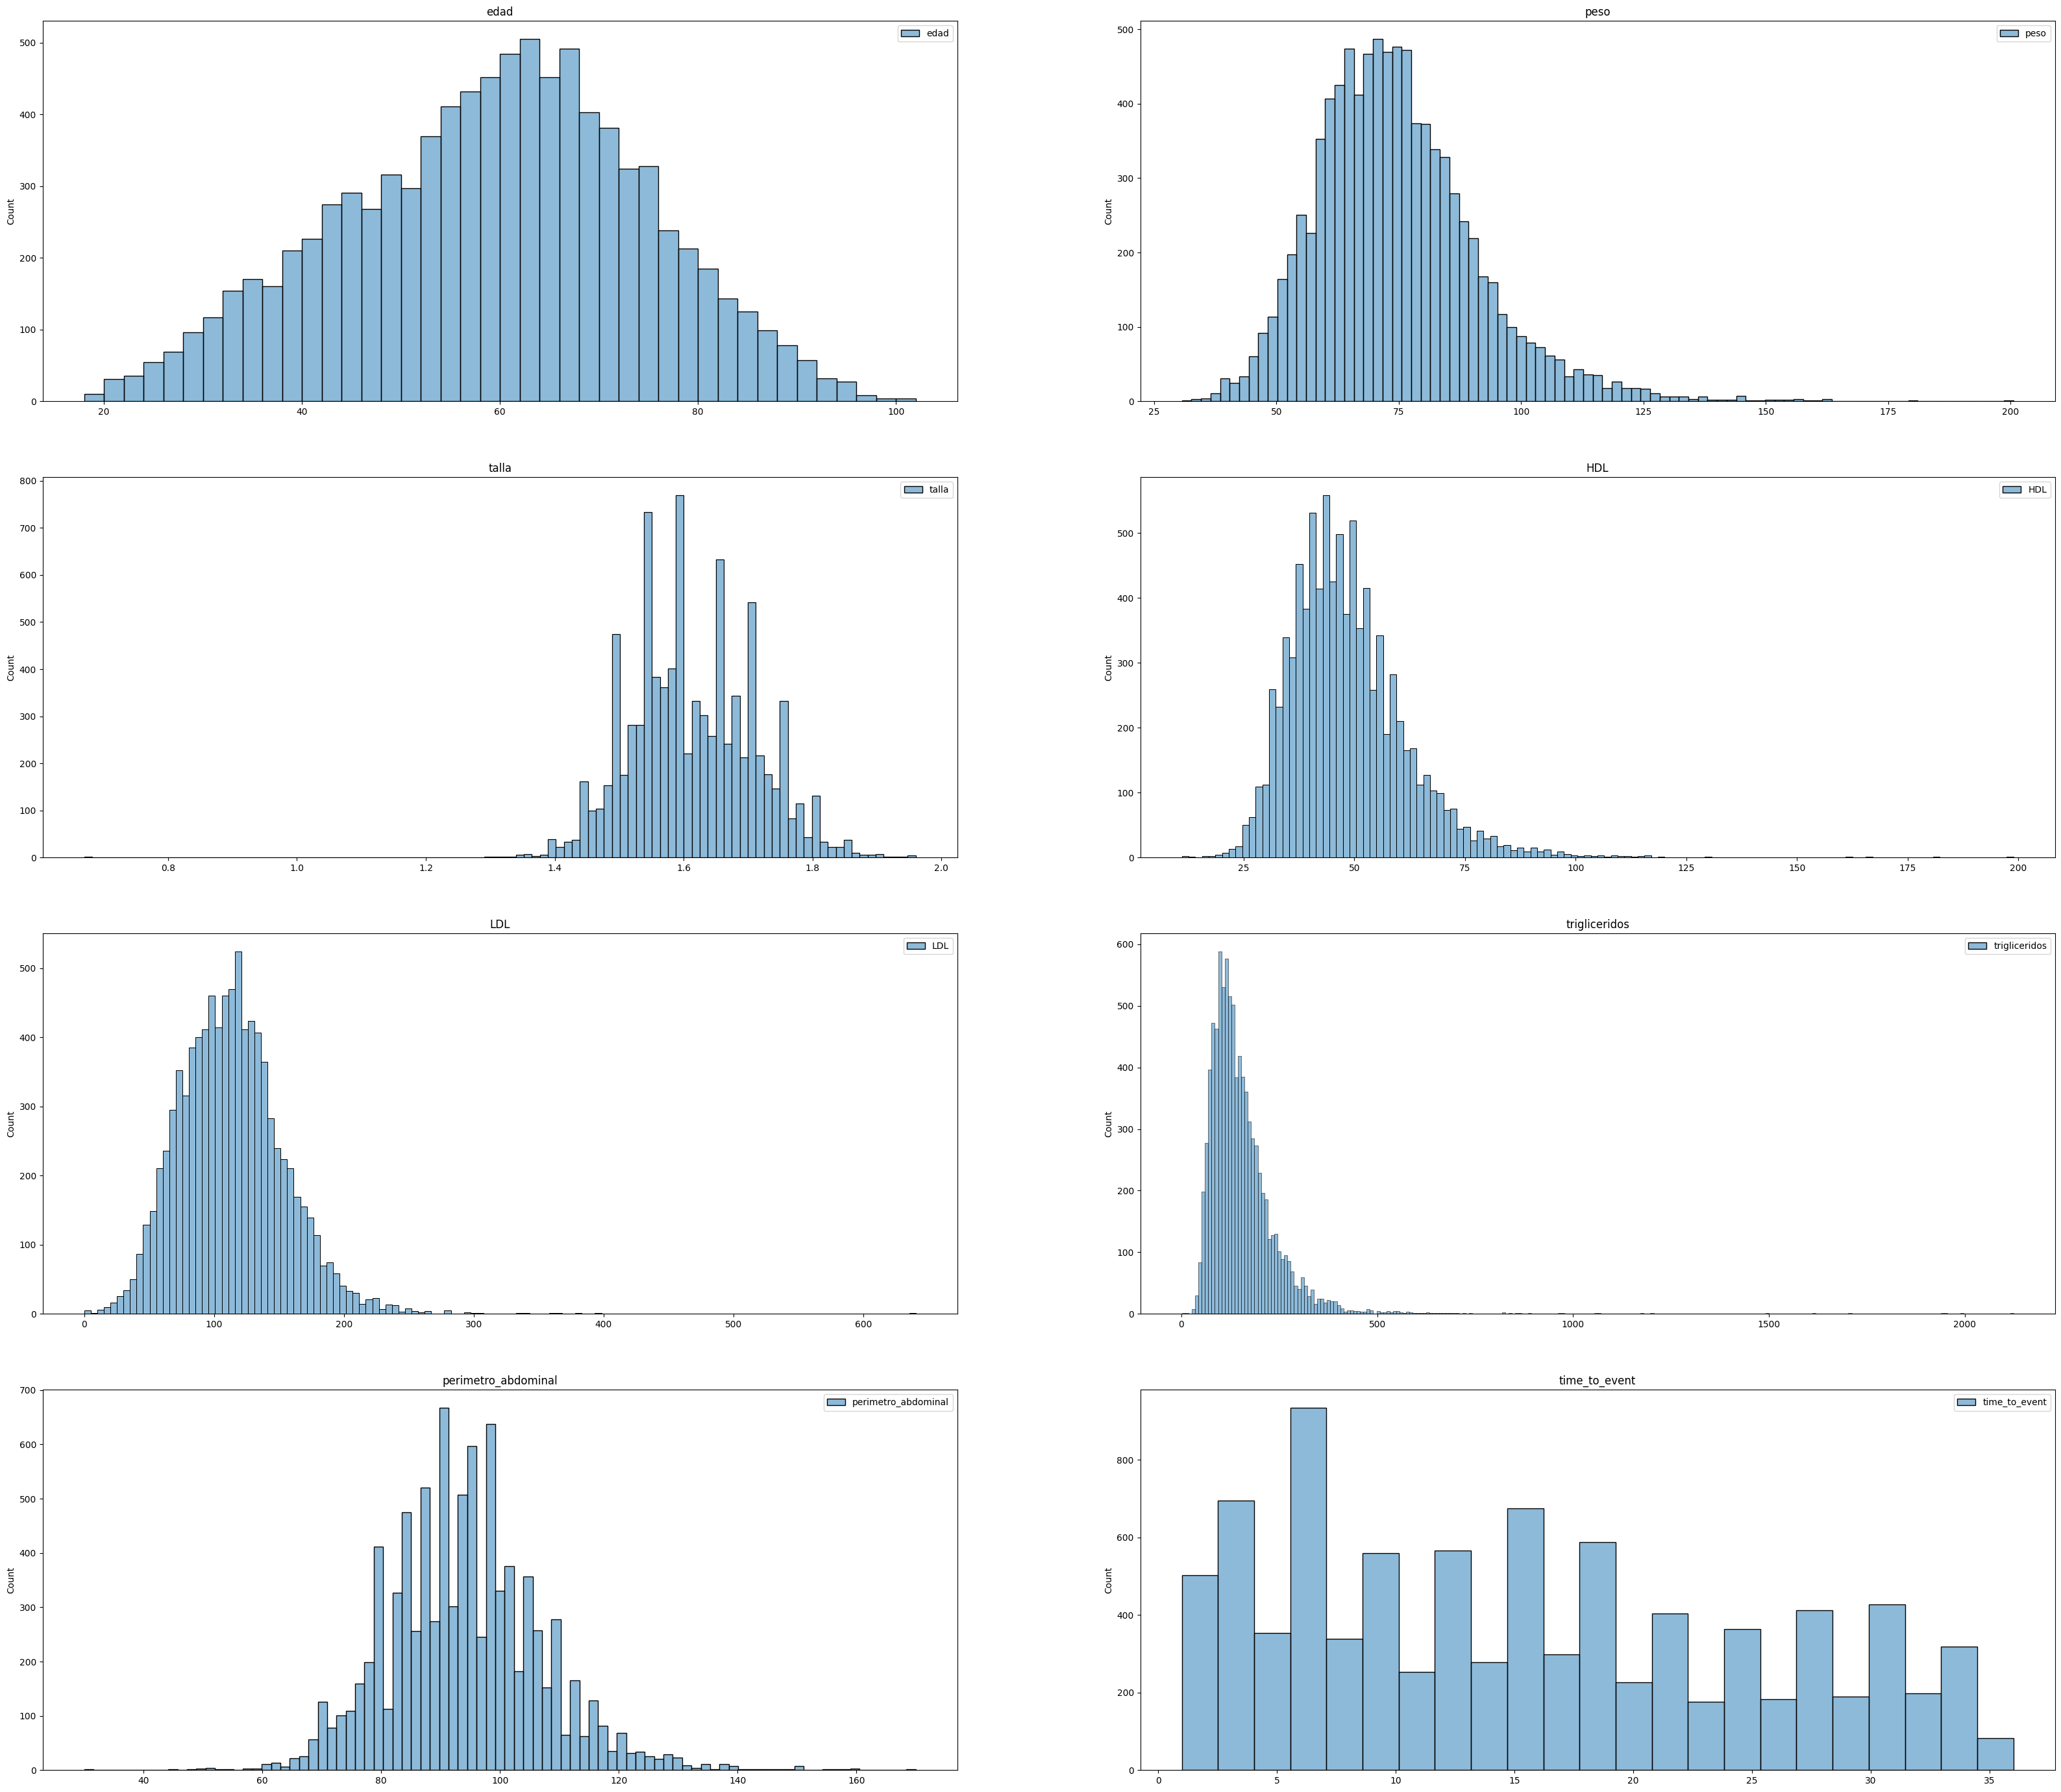

In [12]:
print('Grafico de distribuciones')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.histplot, fig_size = (40,35))
plt.show()

Grafico de caja y bigotes


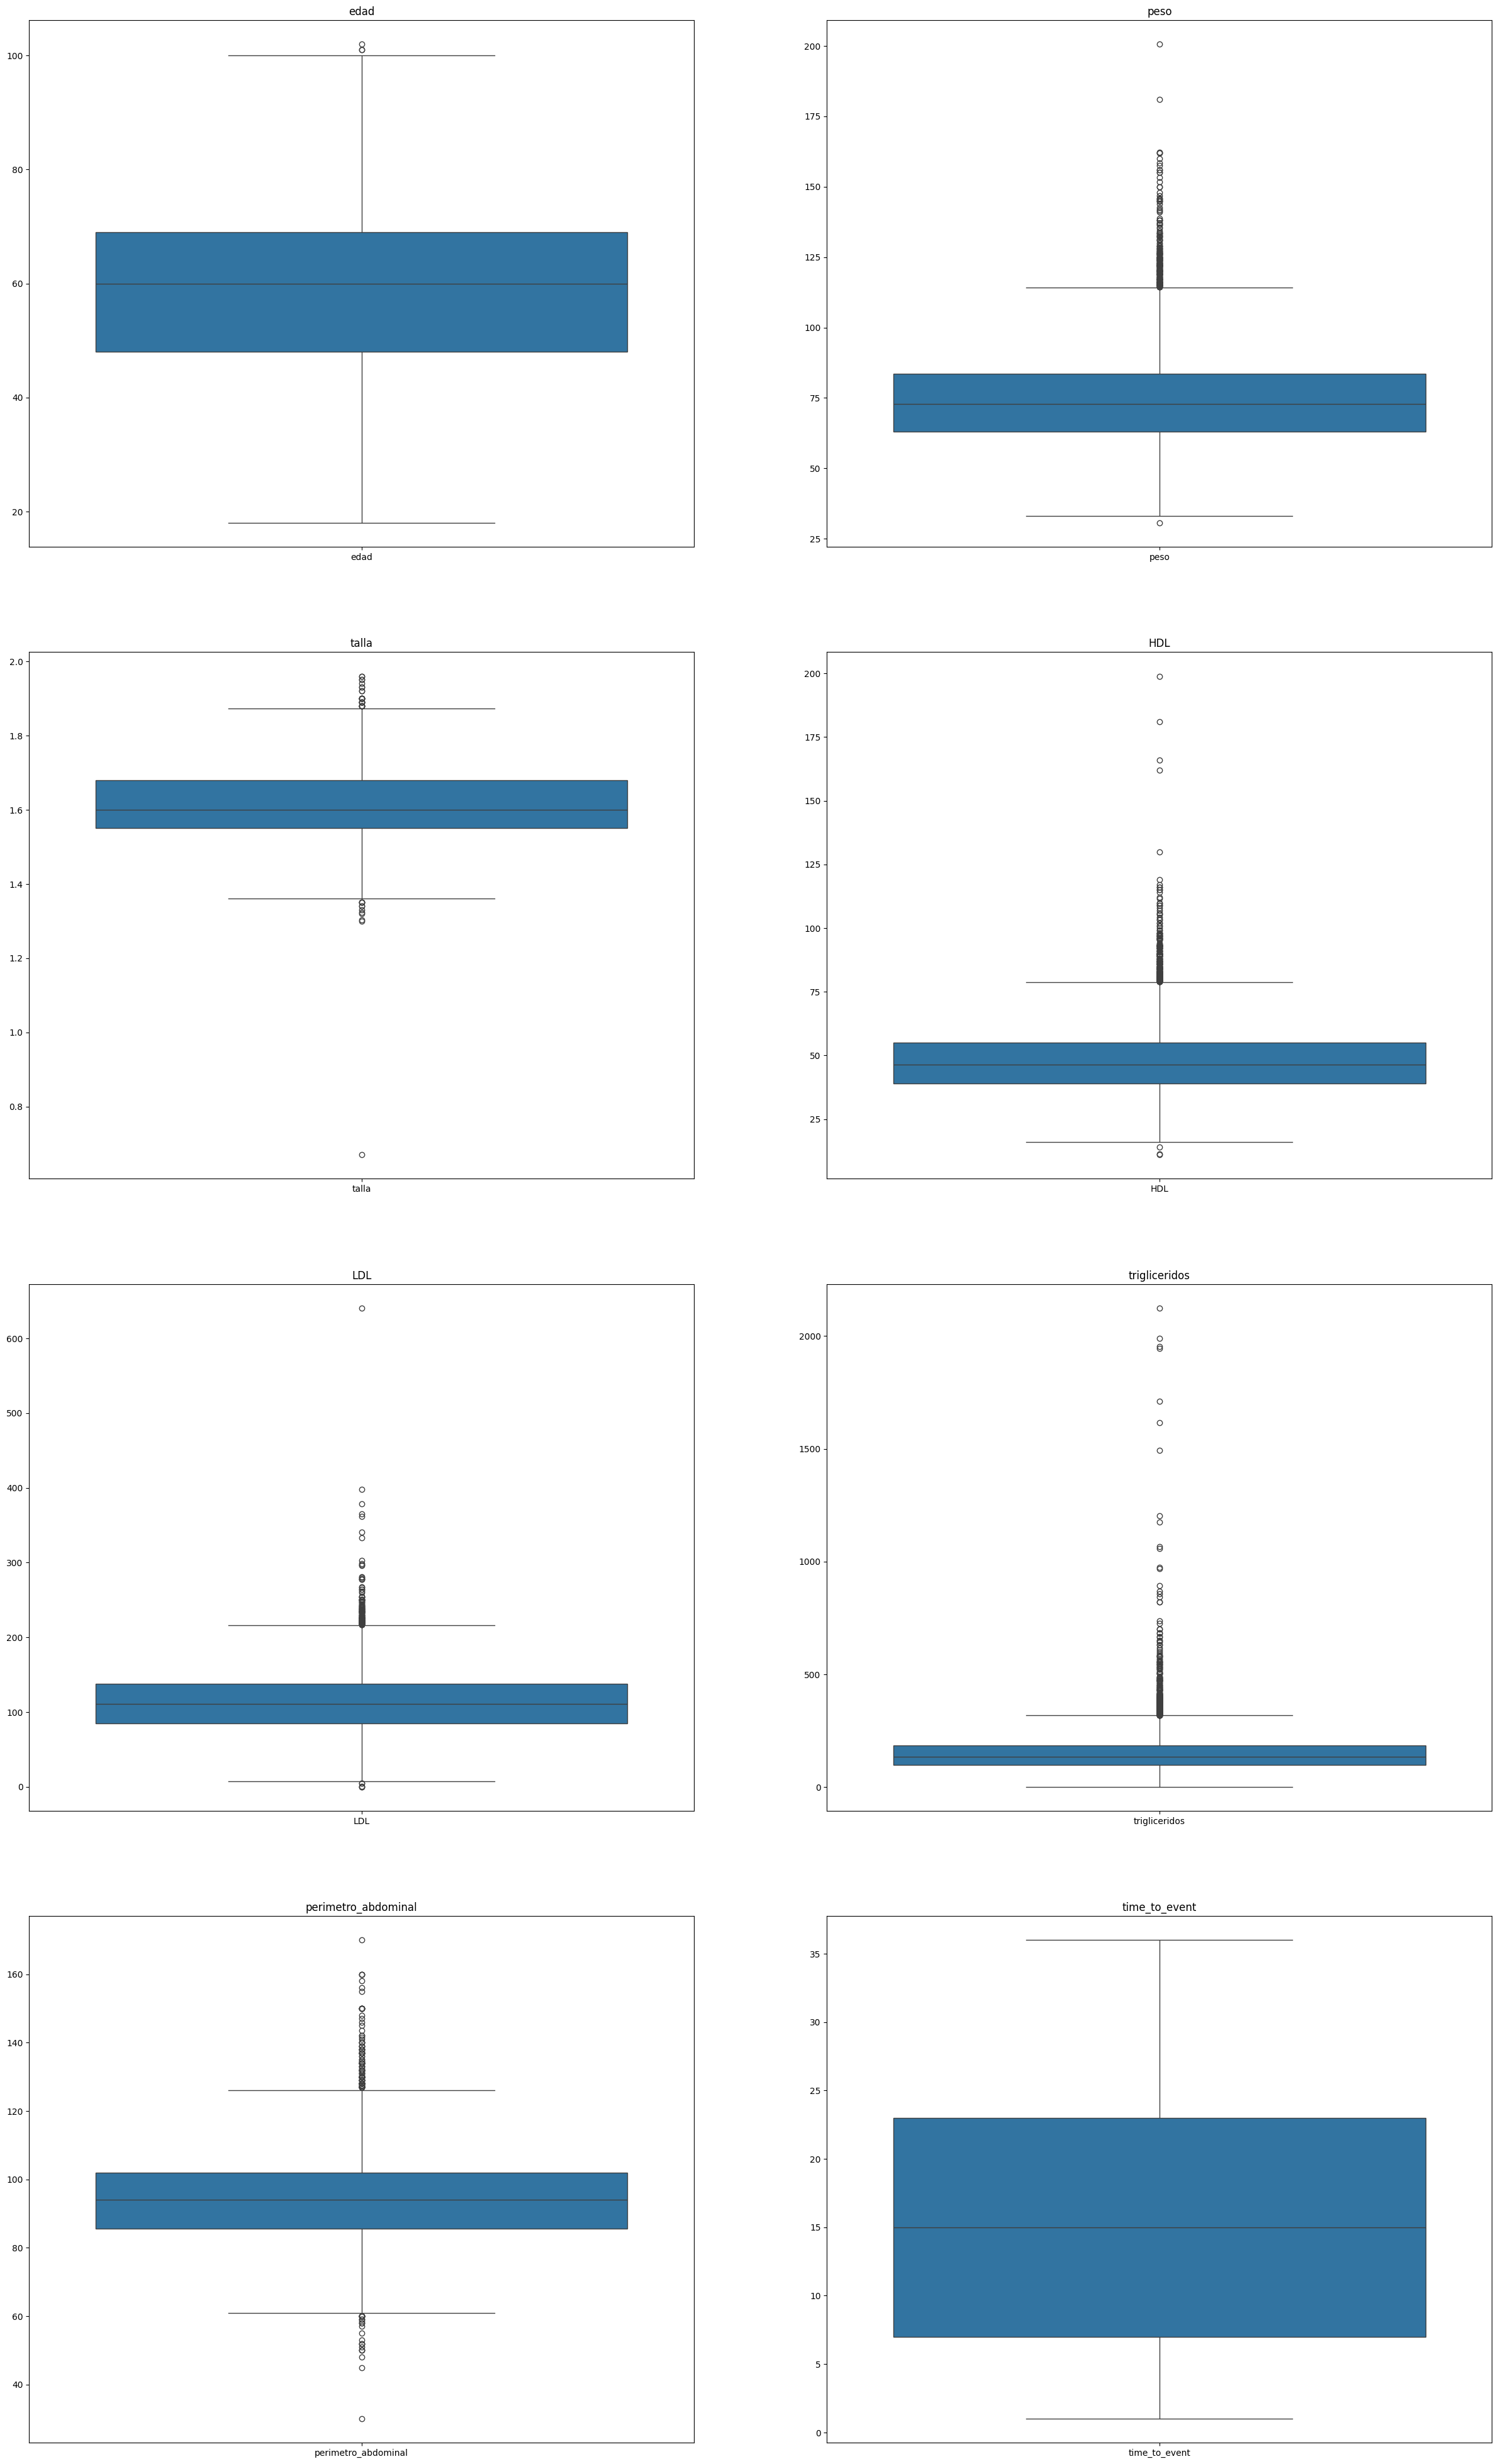

In [13]:
print('Grafico de caja y bigotes')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.boxplot, fig_size=(30,50))
plt.show()

In [14]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9024 entries, 0 to 9023
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   genero_paciente           9024 non-null   object
 1   raza_paciente             9024 non-null   object
 2   nivel_academico_paciente  9024 non-null   object
 3   ant_cardio                9024 non-null   object
 4   med_hipertension          9024 non-null   object
 5   ant_familiar_dm           9024 non-null   object
 6   hace_ejercicio            9024 non-null   object
 7   diabetes                  9024 non-null   object
dtypes: object(8)
memory usage: 564.1+ KB


Conteos de cada una de las categorias


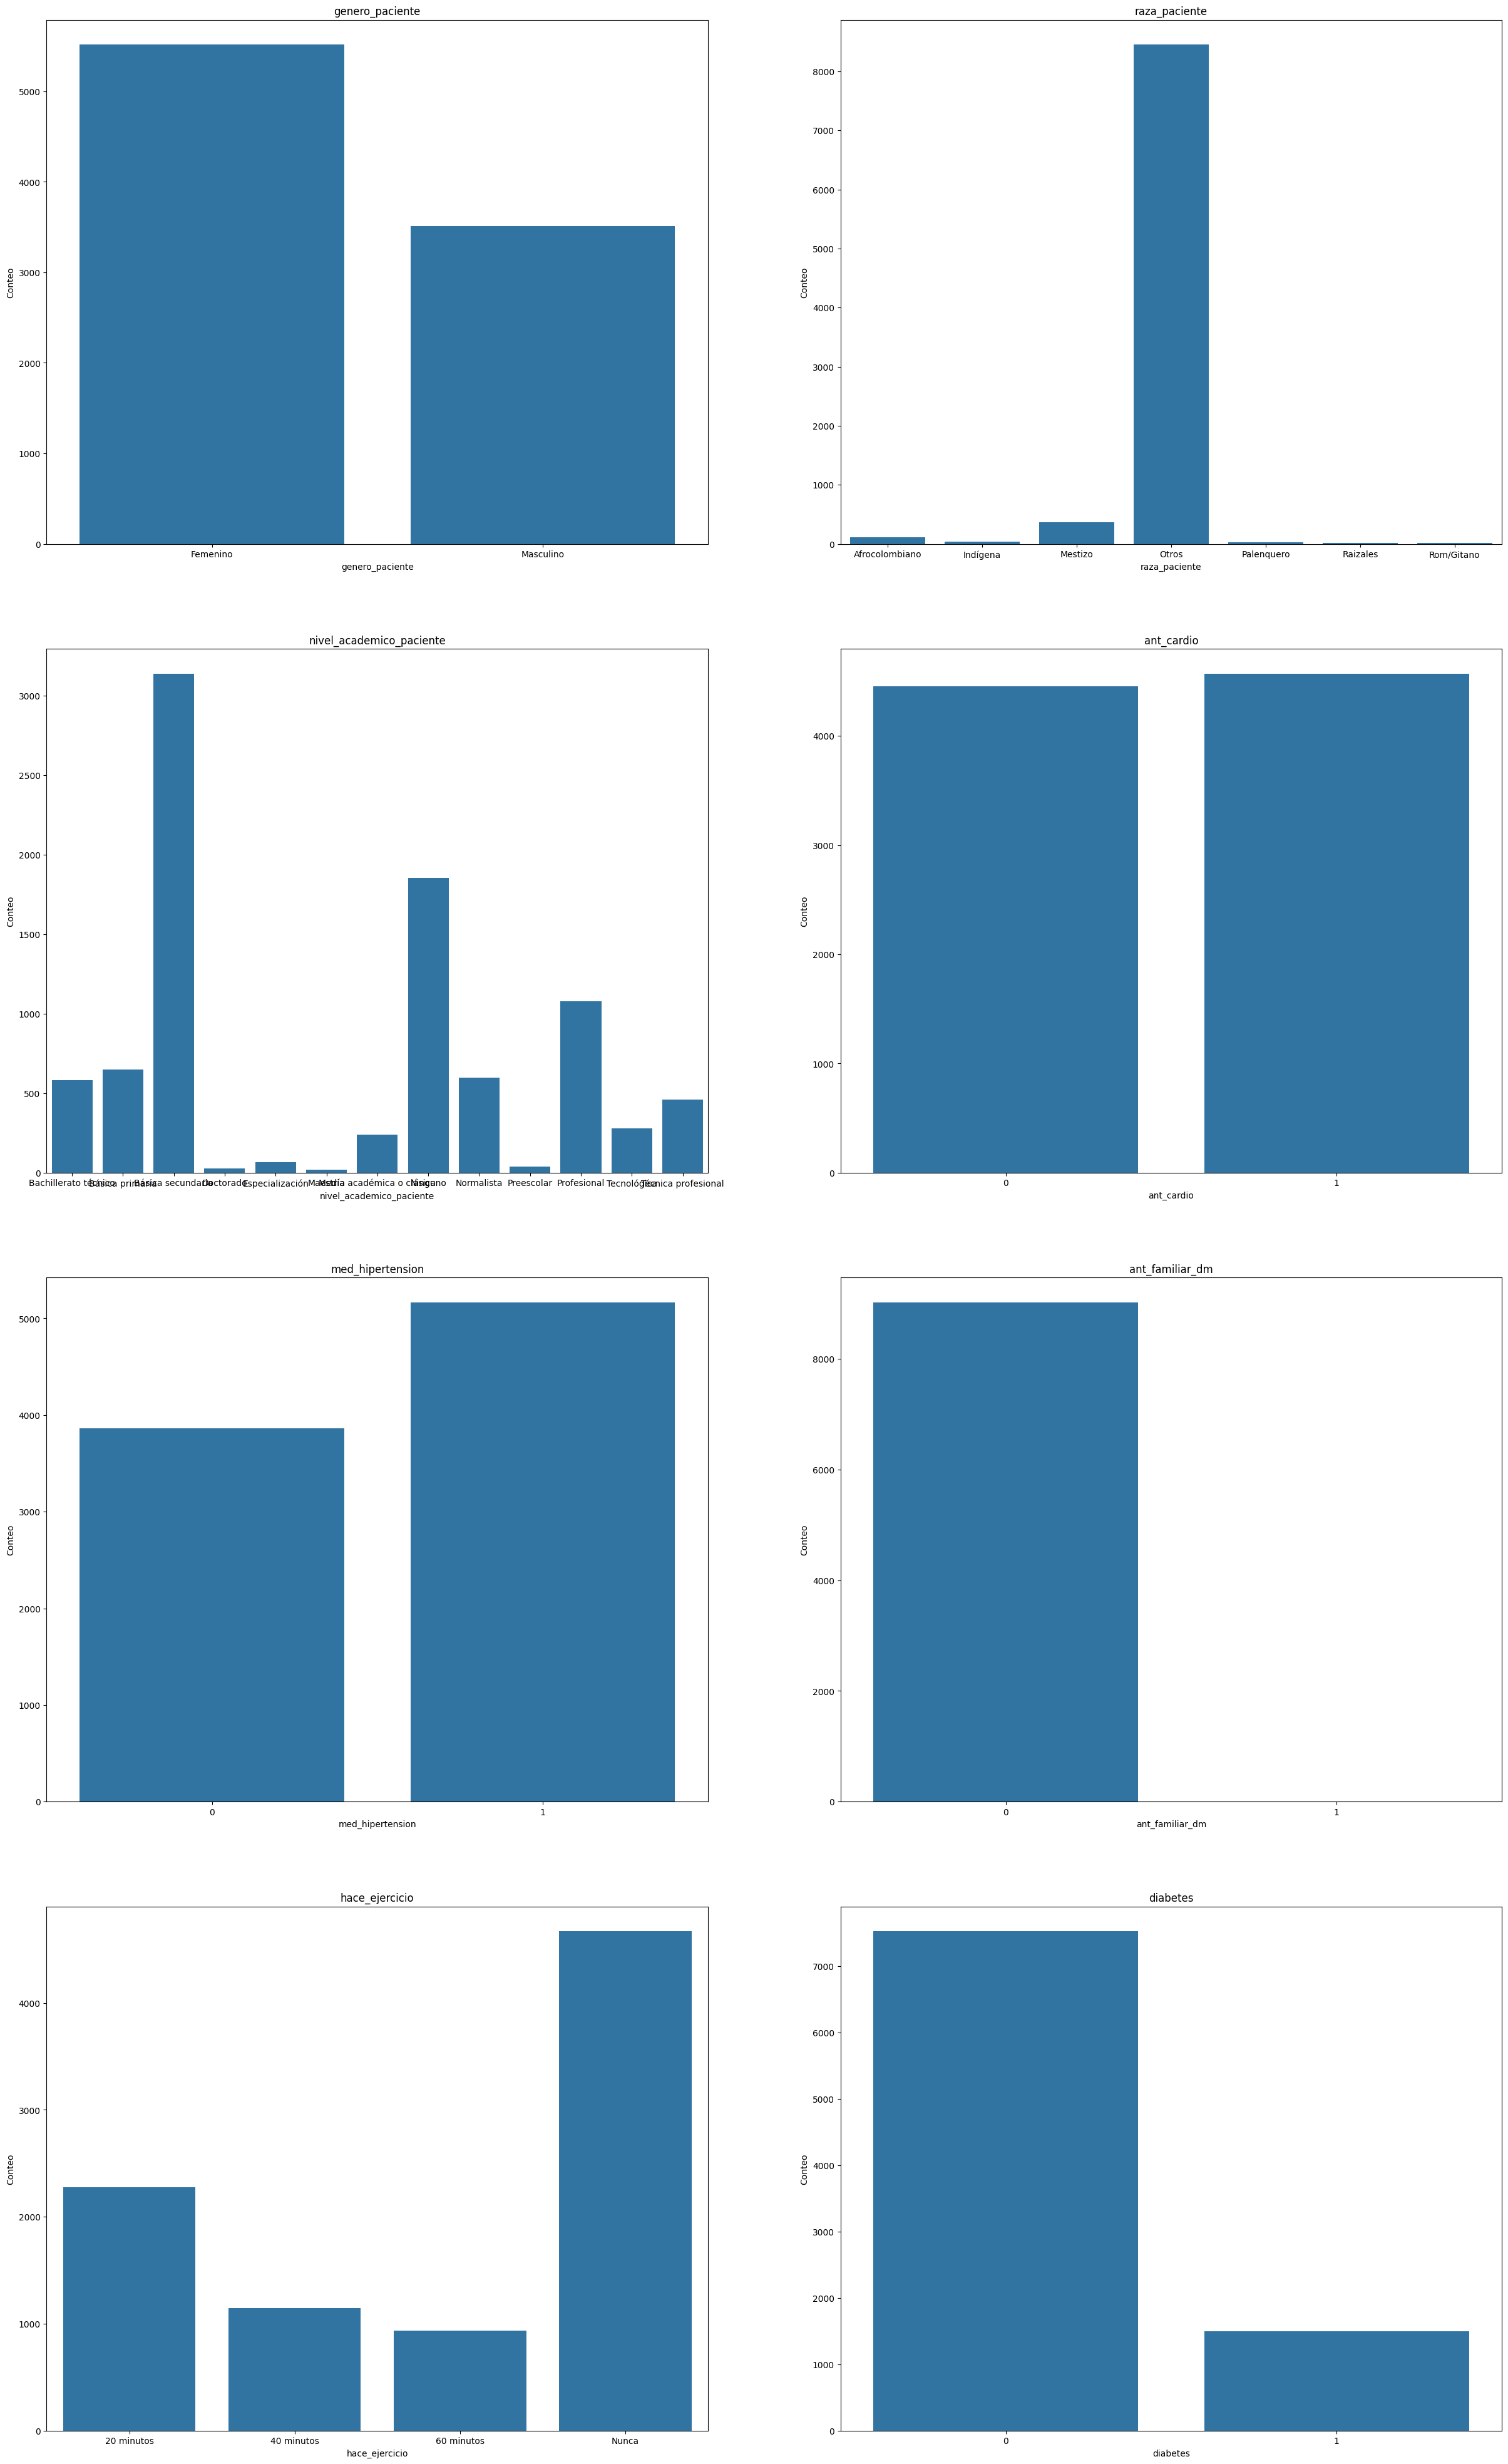

In [15]:
print('Conteos de cada una de las categorias')
fig, axes = graficador.create_subplots_one_var_group(data = df_categorico, n_cols = 2, n_rows = 4, graph= sns.barplot, fig_size=(30,50))
plt.show()

## Two Variables

Grafico de dispersion para cada par de variables


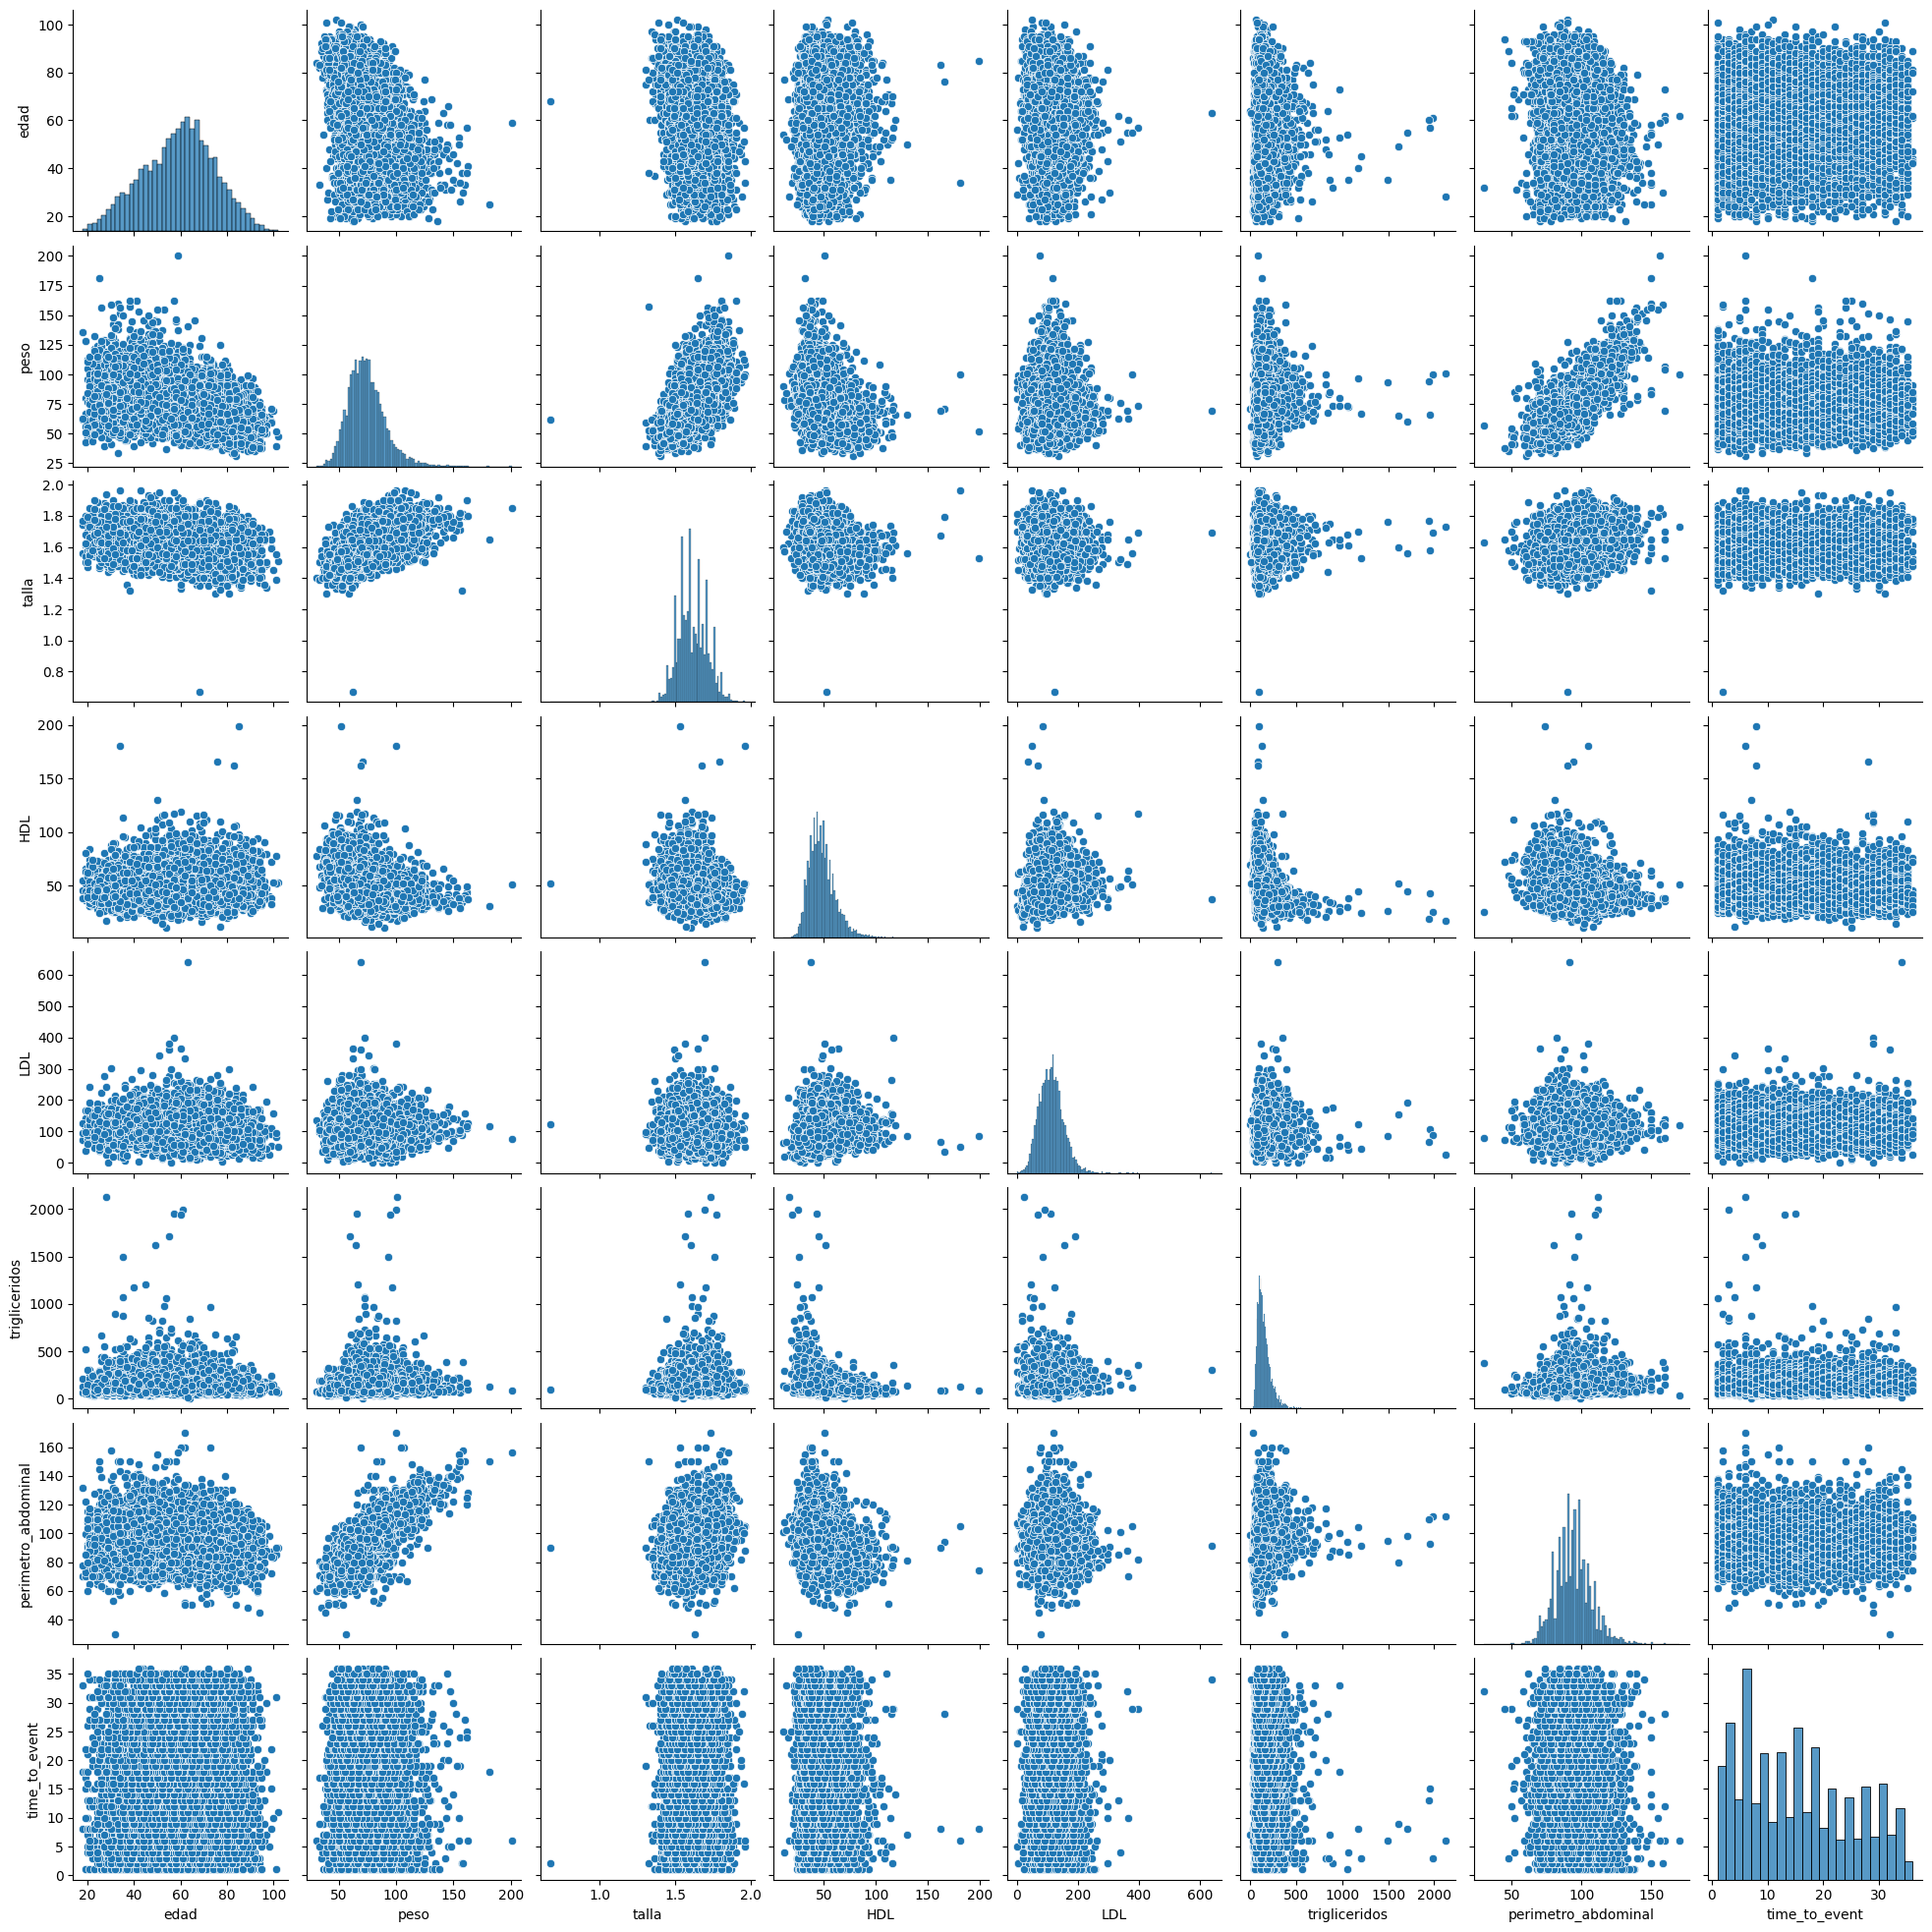

In [16]:
print('Grafico de dispersion para cada par de variables')
sns.pairplot(df_numerico)

In [17]:
print('Matriz de correlaciones')
px.imshow(np.round(df_numerico.corr(),2), text_auto=True, height=500, width=700)

Matriz de correlaciones


In [18]:
print('Matriz de covarianza')
df_numerico.cov()

Matriz de covarianza


,edad,peso,talla,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
edad,234.105697,-83.523095,-0.367389,24.690978,-67.459512,-66.842277,-5.394679,4.636512
peso,-83.523095,272.476935,0.838995,-65.887173,-14.761329,223.956270,160.991126,-2.924782
talla,-0.367389,0.838995,0.009005,-0.296530,-0.173411,0.518073,0.311555,-0.015957
HDL,24.690978,-65.887173,-0.296530,172.044412,49.209754,-444.189774,-44.986030,0.875335
LDL,-67.459512,-14.761329,-0.173411,49.209754,1624.950502,173.260229,-27.796331,1.528181
trigliceridos,-66.842277,223.956270,0.518073,-444.189774,173.260229,9192.882024,187.309381,-3.088900
perimetro_abdominal,-5.394679,160.991126,0.311555,-44.986030,-27.796331,187.309381,166.795901,2.108088
time_to_event,4.636512,-2.924782,-0.015957,0.875335,1.528181,-3.088900,2.108088,92.003276


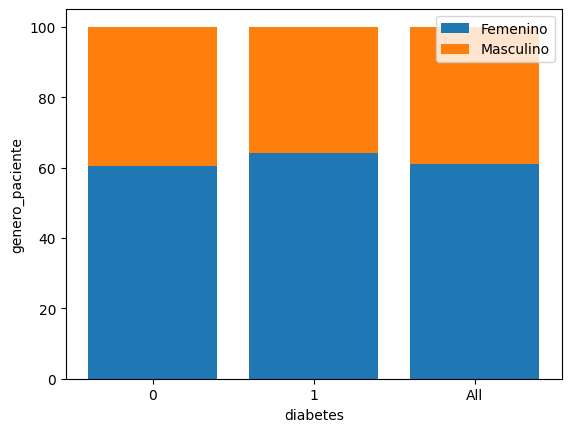

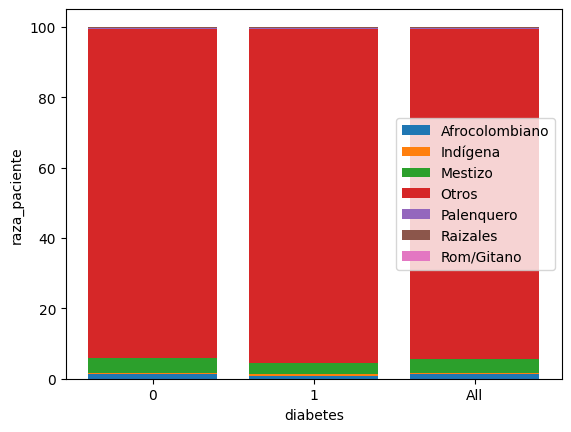

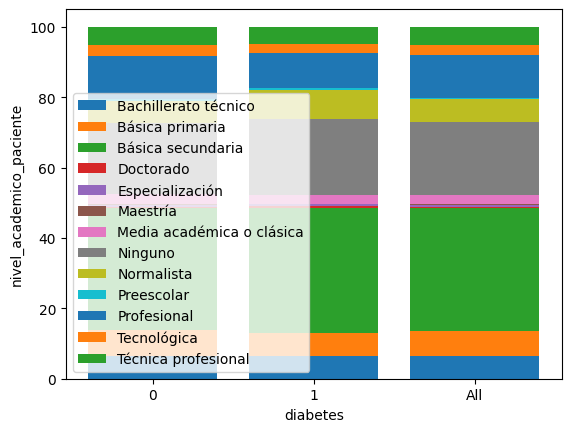

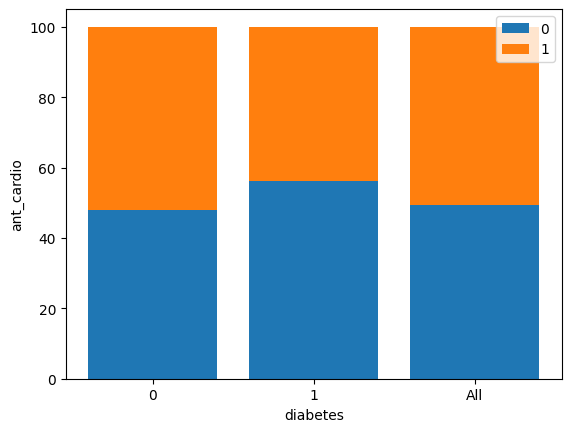

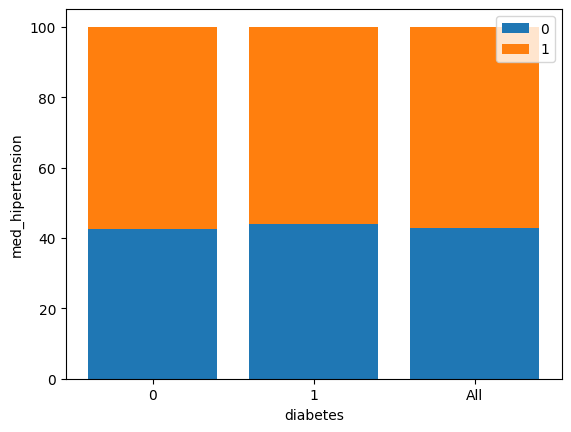

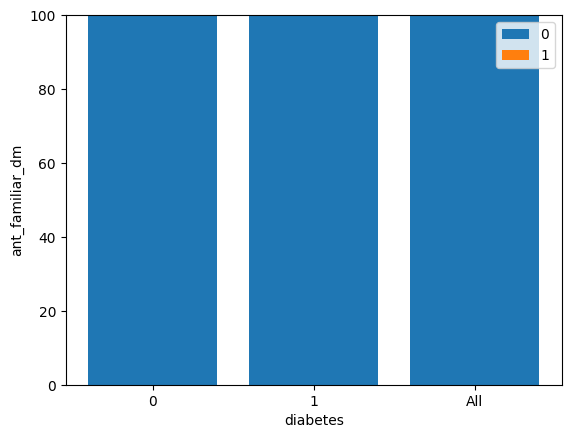

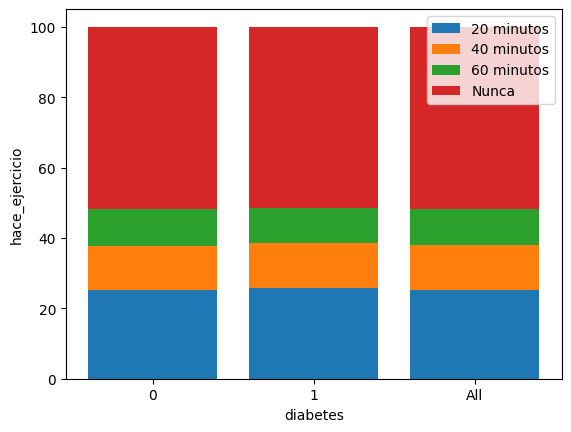

In [19]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    
    # Crear tabla con el perfil columna
    pc = round((pivot/ pivot.loc['All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pc)
    ax.set_xlabel(var2)
    ax.set_ylabel(column)
    plt.legend()


plt.show()

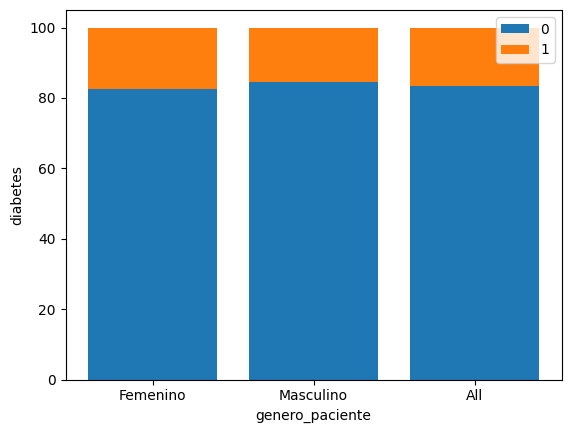

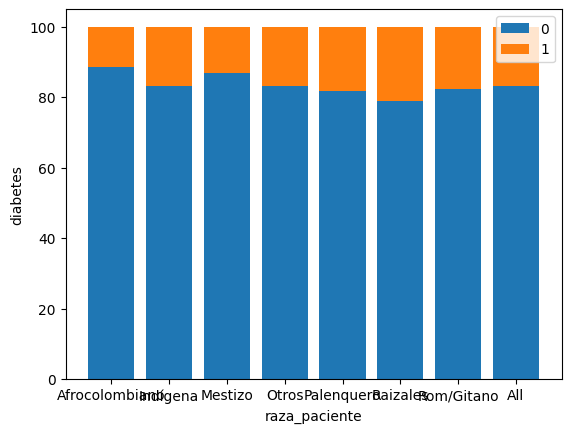

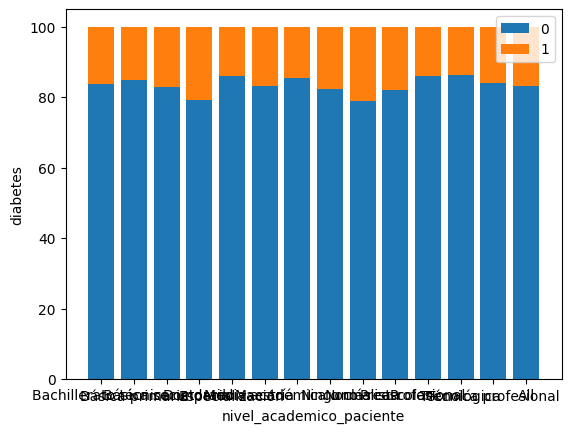

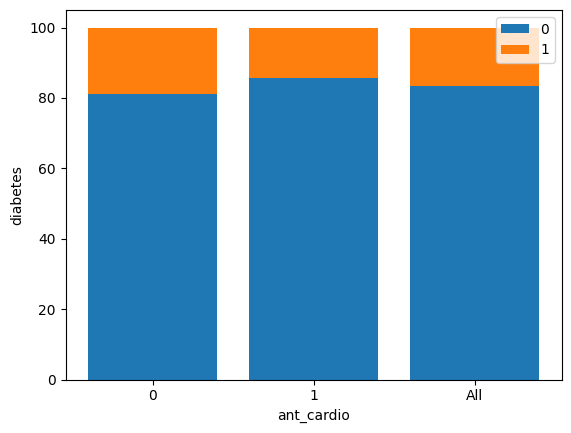

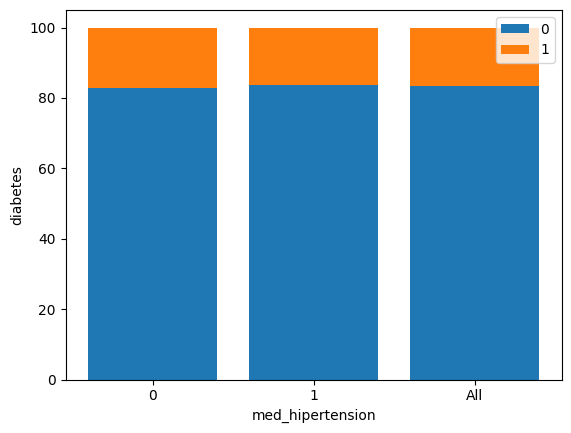

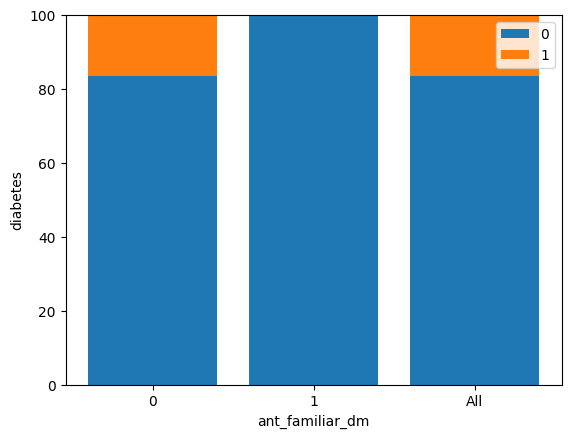

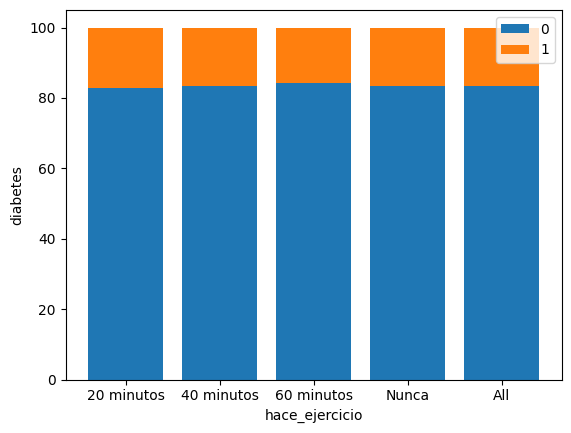

In [20]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    # Crear tabla con el perfil columna
    pf = round((pivot.T/ pivot.loc[:,'All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pf)
    ax.set_xlabel(column)
    ax.set_ylabel(var2)
    plt.legend()


plt.show()